## Imports

In [1]:
import os
import datetime
import logging
import random

import matplotlib.pyplot as plt
import numpy as np

import ocean_navigation_simulator
from ocean_navigation_simulator.problem_factories.SeaweedMissionGenerator import SeaweedMissionGenerator
from ocean_navigation_simulator.utils.misc import get_c3
from ocean_navigation_simulator.utils.misc import set_arena_loggers
from ocean_navigation_simulator.controllers.hj_planners.HJBSeaweed2DPlanner import (
    HJBSeaweed2DPlanner,
)
from ocean_navigation_simulator.environment.SeaweedProblem import SeaweedProblem
from ocean_navigation_simulator.environment.ArenaFactory import ArenaFactory
from ocean_navigation_simulator.problem_factories.Constructor import Constructor
from ocean_navigation_simulator.environment.PlatformState import (
    PlatformState,
    SpatialPoint,
    SpatioTemporalPoint,
)
from ocean_navigation_simulator.utils import units

import os
import pickle
import logging
import datetime




%load_ext autoreload
%autoreload 2

In [2]:
c3 = get_c3()

Starting to connect to c3


## Set up the experiment

In [240]:
experiment_name = "HC_umax_0.5_90_gpu"
exp = c3.Experiment.get(experiment_name)
#exp.remove()

In [ ]:
exp

### Config

In [228]:
arena_config = {
    "casadi_cache_dict": {"deg_around_x_t": 2.0, "time_around_x_t": 432000},
    "platform_dict": {
        "battery_cap_in_wh": 400000.0,
        "u_max_in_mps": 0.5,
        "motor_efficiency": 1.0,
        "solar_panel_size": 100,
        "solar_efficiency": 1,
        "drag_factor": 675.0,
        "dt_in_s": 600.0,
    },
    "use_geographic_coordinate_system": True,
    "spatial_boundary": None,
    "ocean_dict": {
        "keep_newest_days": 365,
        "region": "Region 3",
        "hindcast": {
            "field": "OceanCurrents",
            "source": "hindcast_files",
            "source_settings": {
                "folder": "temp/hindcast/",
                "source": "HYCOM",
                "type": "hindcast",
            },
        },
        "forecast": None,
        # {
        #     "field": "OceanCurrents",
        #     "source": "longterm_average",
        #     "source_settings": {
        #         "forecast": {
        #             "field": "OceanCurrents",
        #             "source": "forecast_files",
        #             "source_settings": {
        #                 "folder": "temp/forecast/",
        #                 "source": "Copernicus",
        #                 "type": "forecast",
        #             },
        #         },
        #         "average": {
        #             "field": "OceanCurrents",
        #             "source": "hindcast_files",
        #             "source_settings": {
        #                 "folder": "/home/c3/.conda/sdsdenvs/py-ocean_sim_matthias/lib/python3.9/site-packages/ocean_navigation_simulator/package_data/monthly_averages/",
        #                 "currents": "normal",
        #             },
        #         },
        #     },
        # },
    },
    "solar_dict": {
        "hindcast": { 
            "field": 'SolarIrradiance',
            "source": 'analytical_wo_caching', # can also be analytical_w_caching
            "source_settings": {
                "boundary_buffer": [0.2, 0.2],
                "x_domain": [-180, 180],
                "y_domain": [-90, 90],
                "temporal_domain": 
                ['2020-01-01T00:00:00+00:00','2023-01-10T00:00:00+00:00'
                    # datetime.datetime(year=2020, month=1, day=1, tzinfo=datetime.timezone.utc),
                    # datetime.datetime(year=2023, month=1, day=10, tzinfo=datetime.timezone.utc),
                ],
                "spatial_resolution": 0.1,
                "temporal_resolution": 3600,
            },
        },
        "forecast": None,
    },
    "seaweed_dict": {
        "hindcast": {
            "field": 'SeaweedGrowth',
            "source": 'GEOMAR',
            "source_settings": {
                "filepath": '/home/c3/.conda/adsdenvs/py-ocean_sim_matthias/lib/python3.9/site-packages/ocean_navigation_simulator/package_data/nutrients/', #'./data/nutrients/2022_monthly_nutrients_and_temp.nc' 
            },
        },
        "forecast": None,
    },
    "timeout": 3600 * 24 * 90, 
}

# change to this if basic setup works
# set_arena_loggers(logging.INFO)
# logging.getLogger("SeaweedMissionGenerator").setLevel(logging.INFO)

config = {
    "scenario_config": arena_config,
    "x_range": [-120, -70],
    "y_range": [0, 20],
    "t_range":
    ["2022-04-14T00:00:00+00:00", "2022-12-29T00:00:00+00:00"
        #datetime.datetime(year=2022, month=7, day=19, tzinfo=datetime.timezone.utc),
        #datetime.datetime(year=2022, month=8, day=20, tzinfo=datetime.timezone.utc),
    ],
    "time_horizon": 7776000, # 3600 * 24 * 30 # in seconds
    "n_samples": 1, # number of start samples per runner
    "min_distance_from_land": 0.5, # degree
}

objectiveConfig = {'type': "max_seaweed"}

### Create Experiment

Make sure you really want to create a new experiment and you ran  ```exp = c3.Experiment.get(experiment_name)``` before
'

In [229]:
# create exp
exp = c3.Experiment.createNew(
    name = experiment_name,
    description = "HC_umax_0.5_90_gpu",
    arenaConfig = arena_config,
    objectiveConfig= objectiveConfig,
    timeout_in_sec=3600 * 24 * 90,
)

In [237]:
exp = exp.get("experimentName")

#name.experimentName = "test_matthias"
#name.merge()
exp

c3.Experiment(
 id='HC_umax_0.5_90_gpu',
 meta=c3.Meta(
        fetchInclude='[experimentName,id,version]',
        fetchType='Experiment'),
 version=1,
 experimentName='HC_umax_0.5_90_gpu',
 T_horizon_FC_Error_Calculation_in_h=96)

# Set up generate mission batch job

## Set up and run mission generation

In [26]:
options = c3.GenMissionBatchJobOptionsMatthias(**{
    'experiment':exp,
    'missGenBatchConfig': config,
    'base_seed': 122,
    'nBatches': 64, 
    'nMissionGenPerBatch': 1,
    'limit': -1,
    'hardwareProfileId': "appc8m642-w" #"appc8m642-w" #appc72m660-w
})

## [Debug locally]


In case you want to debug the Gen Mission c3 stuff locally. Just copy the according code from ```GenMissionBatchJob.py```

In [ ]:
batch = c3.GenMissionBatchJobBatchMatthias(**{'batch_seed': 110})
options = options

In [ ]:
# Set up file paths and download folders
temp_folder = "/tmp/" + str(batch.batch_seed) + "/"
# create the folder if it doesn't exist yet
if not os.path.isdir(temp_folder):
    os.mkdir(temp_folder)
log_file_name = str(batch.batch_seed) + ".log"
logging.basicConfig(filename=temp_folder + log_file_name, level=logging.DEBUG)

# change to this if basic setup works test
set_arena_loggers(logging.INFO)
logging.getLogger("SeaweedMissionGenerator").setLevel(logging.DEBUG)

In [ ]:
# get configs for mission generation
arena_config = options.experiment.get("arenaConfig").arenaConfig
# create the MissionGenerator Config
config = options.missGenBatchConfig

filepath = ocean_navigation_simulator.__file__
module_path = os.path.dirname(filepath)
nutrient_path = module_path + "/package_data/nutrients/"
averages_path = module_path + "/package_data/monthly_averages/"
arena_config["ocean_dict"]["forecast"]["source_settings"]["average"]["source_settings"]["folder"] = averages_path
arena_config["seaweed_dict"]["hindcast"]["source_settings"]["filepath"] = nutrient_path

config_to_add = {
    "scenario_config": arena_config,
    "problem_timeout": datetime.timedelta(
        seconds=options.experiment.get("timeout_in_sec").timeout_in_sec
    ),
    "T_goal_in_seconds": options.experiment.get("timeout_in_sec").timeout_in_sec,
}
config.update(config_to_add)
config_to_add = {
    #"scenario_config": arena_config,
    "problem_timeout": datetime.timedelta(
        seconds=options.experiment.get("timeout_in_sec").timeout_in_sec
    ),
    "T_goal_in_seconds": options.experiment.get("timeout_in_sec").timeout_in_sec,
}

config.update(config_to_add)

In [ ]:
config

In [ ]:
results_folder = "/tmp/missions/"
os.makedirs(results_folder, exist_ok=True)
# seed all of them
random.seed(batch.batch_seed)
all_problems = []
for worker in range(options.nMissionGenPerBatch):
    mission_generator = SeaweedMissionGenerator(
        config=config
        | {
            "seed": int(random.uniform(0, 1000000)),
            "cache_folder": results_folder + str(worker) + "_",
        },
        c3=c3,
    )
    problems = mission_generator.generate_batch()
    all_problems.extend(problems)

# Now upload all of them to the mission database!
exp = options.experiment
for idx, problem in enumerate(all_problems):
    try:
        exp.addMission(missionConfig=problem.to_c3_mission_config(),
                       name="batch_seed_" + str(batch.batch_seed) + "_" + str(idx))
    except BaseException:
        continue

In [ ]:
all_problems

## Start jobs

In [27]:
gen_mission_job = c3.GenMissionBatchJobMatthias(**{'options': options.toJson()}).upsert()
# gen_mission_job.setMaxConcurrency(12) # maybe relevant for GPU nodes
# gen_mission_job.setMaxConcurrencyPerNode(15) # maybe relevant for GPU nodes
gen_mission_job.start()
gen_mission_job

c3.GenMissionBatchJobMatthias(
 typeIdent='BATCHJ:O_MAT_GENMISS_BATCH_JOB',
 id='0178dde6-247c-4eb0-8b58-681d31040bd2',
 meta=c3.Meta(
        created=datetime.datetime(2023, 2, 8, 4, 6, 37, tzinfo=datetime.timezone.utc),
        updated=datetime.datetime(2023, 2, 8, 4, 6, 37, tzinfo=datetime.timezone.utc),
        timestamp=datetime.datetime(2023, 2, 8, 4, 6, 37, tzinfo=datetime.timezone.utc)),
 version=1)

In [125]:
gen_mission_job = c3.GenMissionBatchJobAndreas.get('a319a691-f8d0-49c8-8105-796ae4f95f8a')
gen_mission_job.status()

c3.BatchJobStatus(
 started=datetime.datetime(2023, 2, 8, 23, 49, 53, tzinfo=datetime.timezone.utc),
 startedby='mariuswiggert@berkeley.edu',
 status='running',
 newBatchSubmitted=True)

In [49]:
#gen_mission_job.cancel()

c3.BatchJobStatus(
 started=datetime.datetime(2023, 2, 8, 23, 32, 8, tzinfo=datetime.timezone.utc),
 startedby='mariuswiggert@berkeley.edu',
 completed=datetime.datetime(2023, 2, 8, 23, 46, 5, tzinfo=datetime.timezone.utc),
 status='canceled',
 newBatchSubmitted=True)

In [126]:
gen_mission_job.computingActions()

c3.JobComputingActionsResult(
 actions=c3.Arry<ClusterAction>([c3.ClusterAction(
            id='5991.473231513',
            target='c3/c3/BatchQueue?action=dispatchCompute',
            tenant='c3',
            tag='c3',
            status='Running',
            child=c3.Action(
                    id='5991.473231542',
                    target='seaweed-control/devseaweedrc1/BatchQueue?action=compute',
                    tenant='seaweed-control',
                    tag='devseaweedrc1',
                    status='Running',
                    child=c3.Action(
                            id='5991.473231753',
                            target='seaweed-control/devseaweedrc1/GenMissionBatchJobAndreas?action=dispatchProcessBatch',
                            tenant='seaweed-control',
                            tag='devseaweedrc1',
                            status='Running',
                            child=c3.Action(
                                    id='5991.473232325',
       

In [ ]:
c3.Cluster.actionDump()

In [36]:
#gen_mission_job.cancel()

c3.BatchJobStatus(
 started=datetime.datetime(2023, 2, 8, 21, 25, 31, tzinfo=datetime.timezone.utc),
 startedby='mariuswiggert@berkeley.edu',
 completed=datetime.datetime(2023, 2, 8, 23, 27, 24, tzinfo=datetime.timezone.utc),
 status='canceled',
 newBatchSubmitted=True)

In [61]:
len(exp.get('expMissions').expMissions)

64

In [62]:
exp.get('expMissions').expMissions[0].get('missionConfig')

c3.Mission(
 id='HC_umax_0.5_90_test_mission_nr_0',
 meta=c3.Meta(fetchInclude='[missionConfig,id,version]', fetchType='Mission'),
 version=2,
 missionConfig={'seed': None,
                 'x_0': [{'date_time': '2022-06-04T02:07:17.215119+00:00',
                          'lat': 15.92939562260165,
                          'lon': -100.17848339141537}]})

# Save and load missions from and to experiments instead of generating new ones

### Experiment to take the missions from

In [64]:
problems = []
for miss in exp.get('expMissions').expMissions:
    missionConfig = miss.get("missionConfig").missionConfig
    problems.append(SeaweedProblem.from_c3_mission_config(missionConfig))

In [65]:
import pandas as pd

results_folder = "./"
df = pd.DataFrame([problem.to_dict() for problem in problems])
df['factory_index'] = 0
df.to_csv(results_folder + "problems.csv")

In [197]:
len(problems)

64

TODO: Add funcionality to load missions from .csv

### Make sure you create/select a new experiment where you want to add the retrieved missions to

In [203]:
experiment_name = "HC_umax_0.5_90"
exp = c3.Experiment.get(experiment_name)
#exp.remove()

In [137]:
exp

c3.Experiment(
 id='HC_umax_0.5_90',
 meta=c3.Meta(
        fetchInclude='[experimentName,id,version]',
        fetchType='Experiment'),
 version=1,
 experimentName='HC_umax_0.5_90',
 T_horizon_FC_Error_Calculation_in_h=96)

In [112]:
# exp = c3.Experiment.createNew(
#     name = experiment_name,
#     description = "HC_umax_0.5_90_test",
#     arenaConfig = arena_config,
#     objectiveConfig= objectiveConfig,
#     timeout_in_sec=3600 * 24 * 90,
# )

In [230]:
for problem in problems:
    exp.addMission(problem.to_c3_mission_config())

In [205]:
# for miss in exp.get('expMissions').expMissions:
#     miss.remove()
#     miss.merge()

In [238]:
len(exp.get('expMissions').expMissions)

64

# Plot all of them on a map and get distribution informationm

/var/folders/ng/bpb66jzj5d59g10n121_hj6h0000gn/T/ipykernel_28554/1355533905.py:20: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



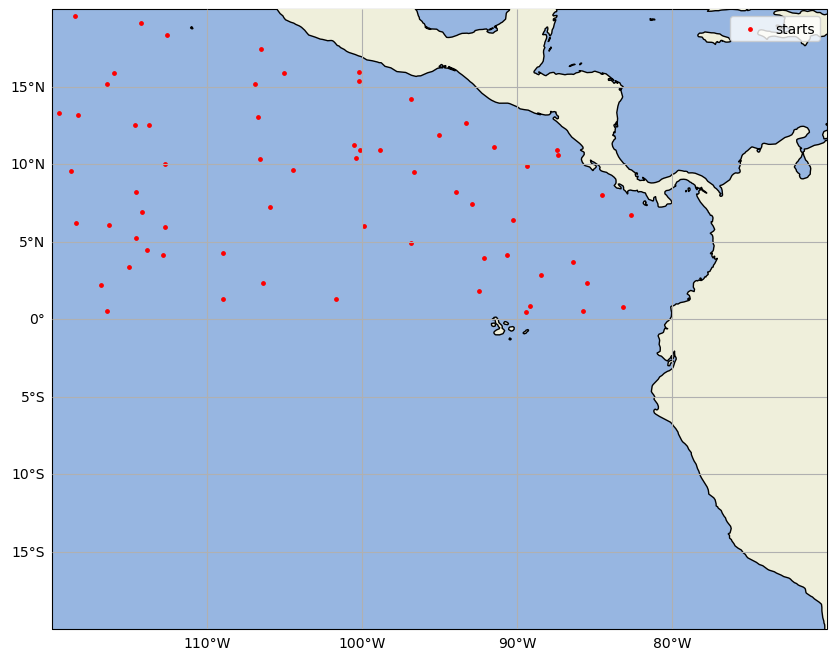

In [67]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
#ax.set_title("Time: " + datetime.fromtimestamp(time, tz=timezone.utc).strftime('%Y-%m-%d %H:%M:%S UTC'))
 
ax.add_feature(cfeature.LAND, zorder=3, edgecolor='black')
ax.add_feature(cfeature.OCEAN, zorder=0)
grid_lines = ax.gridlines(draw_labels=True, zorder=5)
grid_lines.top_labels = False
grid_lines.right_labels = False
ax.axis(xmin=-120,xmax=-70)
ax.axis(ymin=-20,ymax=20)

ax.scatter(df["x_0_lon"], df["x_0_lat"], c="red", marker="o", s=6, label="starts")
ax.legend()
# ax.get_figure().savefig(f"{analysis_folder}starts_and_targets.png")
ax.get_figure().show()

TODO: get time historgram running properly

In [ ]:
#SeaweedMissionGenerator.plot_starts(
#    problems=all_problems, config=arena_config,results_folder= results_folder,
#)

ValueError: invalid literal for int() with base 10: '2022-06-04T02:07:17.215119+00:00'

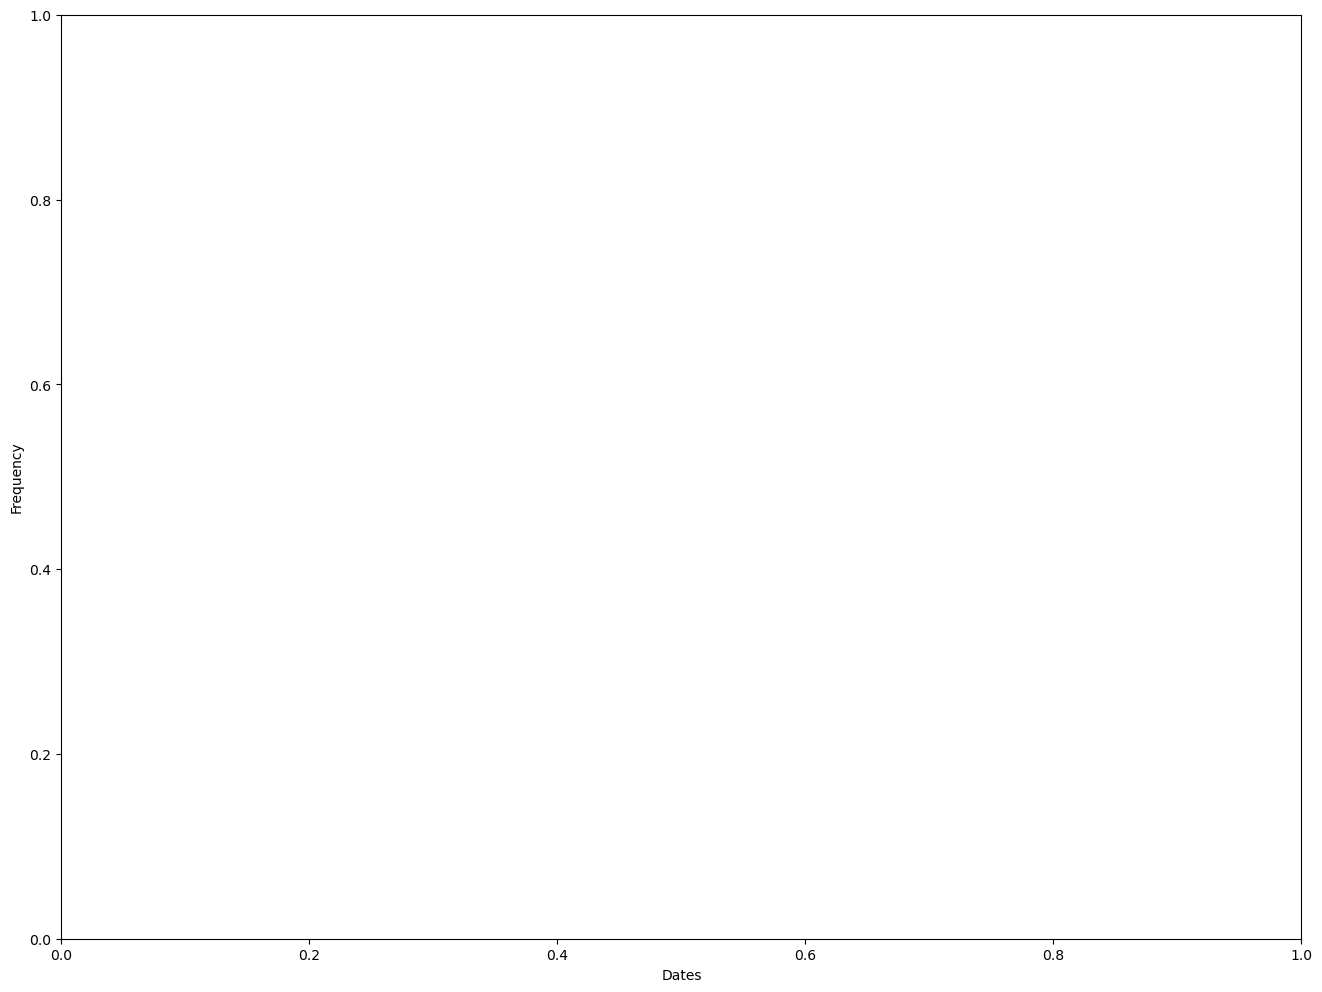

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(16, 12))

# Add labels to the x and y axis
plt.xlabel('Dates')
plt.ylabel('Frequency')

days = pd.date_range(
    df["t_0"].min(),
    df["t_0"].max(),
    freq="D",
)
months = pd.date_range(
    df["t_0"].min(),
    df["t_0"].max(),
    freq="MS",
)

df["t_0"].astype(np.int64).plot.hist(ax=ax, bins=days.astype(np.int64), rwidth=0.85)

# Set the x-axis ticks to show a label every year
ax.set_xticks(months.astype(np.int64).to_list())
ax.set_xticklabels(months.strftime("%Y-%m").to_list(), rotation=45)

unique_days = len(df["t_0"].unique())
fig.suptitle(f"Target Day Histogram (Days: {unique_days})")

# Show the plot
fig.show()


In [ ]:
GenerationRunner.plot_ttr_histogram(results_folder)

# Add Observer

In [242]:
# Config for No observer
observer_config = {"observer": None}
# add observer
exp.addObserver(name="NoObserver", observerConfig=observer_config)

ValueError: Observer with the same name already exists, check name & settings.

The traceback for the inline method is:
  File "Zc0f5ed362f587e2990729fbf1913b613M_.TypeSystemBase", line 1015, in inline_traceback_impl
  File "Experiment.py", line 56, in addObserver
    raise ValueError("Observer with the same name already exists, check name & settings.")


### other observer configs

In [ ]:
# Config for GP observer
observer_config = {
    "observer": {
        "model": {
            "gaussian_process": {
                "sigma_exp_squared": 5.011571057964094, 
                "kernel": {
                    "scaling": {
                        "latitude": 0.5753005356364821,
                        "longitude": 0.5967749664273109,
                        "time": 42103.57591355196},  # [m]  # [m]  # [s]
                    "type": "matern",
                    "parameters": {
                        "length_scale_bounds": "fixed",
                        "nu": 1.5},
                },
            }
        },
    }
}

# add observer
exp.addObserver(name="GPObserver", observerConfig=observer_config)

In [ ]:
# Config for GP_NN_Observer
observer_config = {
    'observer': {
        'life_span_observations_in_sec': 86400,
        'model': {
            'NN': {
                'NN_radius_space': 1,
                'NN_lags_in_second': 43200,
                'dimension_input': [12, 13, 13],
                'model_error': False,
                'type': 'cnn',
                'parameters': {
                    'path_weights': 'ocean_navigation_simulator/forecast_improvement/CNN_models_saved/medium_tile_big_ds.h5',
                    'ch_sz': [6, 24, 48, 96, 192],
                     'downsizing_method': 'avgpool',
                     'dropout_encoder': 0.24299222476871712,
                     'dropout_decoder': 0.13587898683659105,
                     'dropout_bottom': 0.7479602916555403,
                     'initial_channels': [0, 1, 2, 3, 6, 7],
                     'output_paddings': [[0, 1, 1], [1, 0, 0], [1, 0, 0]]}},
            'gaussian_process': {
                'kernel': {
                    'type': 'matern',
                    'sigma_exp_squared': 5.011571057964094,
                    'scaling': {
                        'latitude': 0.5753005356364821,
                        'longitude': 0.5967749664273109,
                        'time': 42103.57591355196},
                    'parameters': {'length_scale_bounds': 'fixed', 'nu': 1.5}}}}}}
# add observer
exp.addObserver(name="GP_NN_Observer", observerConfig=observer_config)

# Add Controller

In [243]:
# Config for Controller
ctrl_config = {
    "ctrl_name": "ocean_navigation_simulator.controllers.hj_planners.HJBSeaweed2DPlanner.HJBSeaweed2DPlanner",
    "replan_on_new_fmrc": True,
    "replan_every_X_seconds": False,
    "direction": "backward",
    "n_time_vector": 24*90,
    # Note that this is the number of time-intervals, the vector is +1 longer because of init_time
    "deg_around_xt_xT_box_global": 25,  # area over which to run HJ_reachability on the first global run
    "deg_around_xt_xT_box": 1.4,  # area over which to run HJ_reachability
    "accuracy": "high",
    "artificial_dissipation_scheme": "local_local",
    "T_goal_in_seconds": 3600 * 24 * 90,
    "use_geographic_coordinate_system": True,
    "progress_bar": True,
    "grid_res": 0.0833,  # Note: this is in deg lat, lon (HYCOM Global is 0.083 and Mexico 0.04)
    "grid_res_global": 0.166,  # Note: this is in deg lat, lon (HYCOM Global is 0.083 and Mexico 0.04)        
    "d_max": 0.0,
    "calc_opt_traj_after_planning": False
}

In [244]:
# add controller
exp.addController(name='SeaweedHJController_25_deg_test_gpu', ctrlConfig=ctrl_config)

c3.ControllerSetting(
 id='HC_umax_0.5_90_gpu_SeaweedHJController_25_deg_test_gpu',
 name='SeaweedHJController_25_deg_test_gpu',
 meta=c3.Meta(
        created=datetime.datetime(2023, 2, 9, 3, 56, 52, tzinfo=datetime.timezone.utc),
        updated=datetime.datetime(2023, 2, 9, 3, 56, 52, tzinfo=datetime.timezone.utc),
        timestamp=datetime.datetime(2023, 2, 9, 3, 56, 52, tzinfo=datetime.timezone.utc)),
 version=1)

In [36]:
ctrl_config = {
    "ctrl_name": "ocean_navigation_simulator.controllers.NaiveController.NaiveController"}
# add controller
exp.addController(name="NaiveToTarget", ctrlConfig=ctrl_config)

c3.ControllerSetting(
 id='matthias_wandb_2_NaiveToTarget',
 name='NaiveToTarget',
 meta=c3.Meta(
        created=datetime.datetime(2023, 1, 30, 20, 5, 27, tzinfo=datetime.timezone.utc),
        updated=datetime.datetime(2023, 1, 30, 20, 5, 27, tzinfo=datetime.timezone.utc),
        timestamp=datetime.datetime(2023, 1, 30, 20, 5, 27, tzinfo=datetime.timezone.utc)),
 version=1)

# [Run Feasibility Check Batch Job]

In [ ]:
filterOnMissions = 'status ==' + '"' + 'staged_for_feasibility' + '"'
options = c3.FeasibilityCheckBatchJobOptions(**{
    'experiment':exp,
    'limit': -1,
    'filterOnMissions': filterOnMissions
})

In [ ]:
exp

In [ ]:
feas_job = c3.FeasibilityCheckBatchJob(**{'options': options.toJson()}).upsert()
# feas_job.setMaxConcurrency(12)
# feas_job.setMaxConcurrencyPerNode(15)
feas_job.start()
feas_job

In [ ]:
feas_job = c3.FeasibilityCheckBatchJob.get('2d084cad-1771-4e09-b826-98b2bef29478')
feas_job.status()

In [ ]:
experiment = 'experiment.id==' + '"' + exp.id + '"'
objs_list = c3.Mission.fetch(spec={'include': "[this]",'filter':  experiment}).objs
print("Total of {} Missions".format(len(objs_list)))

staged_for_feasibility = 0
running_feasibility = 0
not_feasible = 0
ready_to_run = 0
feasibility_failed = 0

for run in objs_list:
    if run.status == 'staged_for_feasibility':
        staged_for_feasibility += 1
    elif run.status == 'running_feasibility':
        running_feasibility += 1
    elif run.status == 'not_feasible':
        not_feasible += 1
    elif run.status == 'ready_to_run':
        ready_to_run += 1
    elif run.status == 'feasibility_failed':
        feasibility_failed += 1

print("staged_for_feasibility: ", staged_for_feasibility)
print("running_feasibility: ", running_feasibility)
print("not_feasible: ", not_feasible)
print("feasibility_failed: ", feasibility_failed)
print("ready_to_run: ", ready_to_run)

In [ ]:
experiment = 'experiment.id==' + '"' + exp.id + '"'
status = ' && status==' + '"not_feasible"'
ro_remove_list = c3.Mission.fetch(spec={'include': "[this]",'filter':  experiment + status}).objs

In [ ]:
ro_remove_list

In [ ]:
for miss in ro_remove_list:
    miss.remove()

# Set missions to ready to run

In [245]:
experiment = 'experiment.id==' + '"' + exp.id + '"'
status = ' && status==' + '"staged_for_feasibility"'
exp_list = c3.Mission.fetch(spec={'include': "[this]",'filter':  experiment + status}).objs

In [246]:
len(exp_list)

64

In [ ]:
experiment

'experiment.id=="HC_umax_0.5_90"'

In [247]:
for miss in exp_list:
    miss.status="ready_to_run"
    miss.merge()
    #print(miss.status)

## Test feasibility manually

In [ ]:
# Seems like the problem is with mission generation then, that they are unrealistic...

In [ ]:
import os
import pickle
import logging
import datetime

from ocean_navigation_simulator.environment.ArenaFactory import ArenaFactory
from ocean_navigation_simulator.problem_factories.Constructor import Constructor
from ocean_navigation_simulator.environment.PlatformState import SpatioTemporalPoint
from ocean_navigation_simulator.utils.calc_fmrc_error import calc_fmrc_errors
from ocean_navigation_simulator.utils.misc import set_arena_loggers
set_arena_loggers(logging.DEBUG)


def set_up_time_optimal_controller_config(this):
    ctrl_config = {
        "ctrl_name": "ocean_navigation_simulator.controllers.hj_planners.HJReach2DPlanner.HJReach2DPlanner",
        "replan_on_new_fmrc": False,
        "replan_every_X_seconds": False,
        "direction": "multi-time-reach-back",
        "n_time_vector": 200,
        "deg_around_xt_xT_box": this.experiment.feasibilityCheckSettings.deg_around_xt_xT_box,
        "accuracy": "high",
        "artificial_dissipation_scheme": "local_local",
        "T_goal_in_seconds": this.experiment.timeout_in_sec,
        "use_geographic_coordinate_system": True,
        "progress_bar": False,
        "grid_res": this.experiment.feasibilityCheckSettings.grid_res,
        "d_max": 0.0,
    }
    return ctrl_config

In [ ]:
this = exp.get('expMissions').expMissions[0]

In [ ]:
"""Function to check 2D time-optimal feasibility of the mission with specific specs defined in Experiment."""

# ensure we have all necessary data to run
this = this.get("missionConfig, experiment.timeout_in_sec," +
                "experiment.arenaConfig, experiment.objectiveConfig,"+
                "experiment.feasibilityCheckSettings.deg_around_xt_xT_box,"+
                "experiment.feasibilityCheckSettings.grid_res")

# Step 1 update the entry while running feasibility
updated_miss = c3.Mission(**{'id': this.id, 'status': 'running_feasibility'})
updated_miss.merge()

# Step 2: check if it is a navigation problem otherwise return Error
if not this.experiment.objectiveConfig['type'] == "nav":
    e = "Type Error: objectiveConfig['type'] needs to be 'nav' otherwise feasibility not defined."
    updated_miss.oceanSimResult = c3.OceanSimResult(**{'error_message': e})
    updated_miss.merge()
    print("in the wrong place")
#     return updated_miss

# Set up file paths and download folders
temp_folder = '/tmp/' + this.id + '/'
# create the folder if it doesn't exist yet
if not os.path.isdir(temp_folder):
    os.mkdir(temp_folder)
log_file_name = this.id + ".log"
logging.basicConfig(filename=temp_folder + log_file_name, level=logging.DEBUG)
traj_file_name = this.id + '.obj'
extDir = "ocean_sim_run_results/" + this.experiment.id + '/MissionFeasibility/' + this.id

# set download directories (ignore set ones in arenaConfig)
arenaConfig = this.experiment.arenaConfig
arenaConfig['timeout'] = this.experiment.timeout_in_sec

# for hindcast
arenaConfig['ocean_dict']['hindcast']['source_settings']['folder'] = '/tmp/hindcast_files/' + this.id + '/'
# set forecast to none
arenaConfig['ocean_dict']['forecast'] = None

# prepping the file download
point_to_check = SpatioTemporalPoint.from_dict(this.missionConfig['x_0'][0])
t_interval = [point_to_check.date_time,
              point_to_check.date_time + datetime.timedelta(
                  seconds=this.experiment.timeout_in_sec + arenaConfig['casadi_cache_dict'][
                      'time_around_x_t'])]
feasible = None

arena = None

# Step 1: Download all relevant files (only Hindcast files needed)
with ArenaFactory.download_files(
        config=arenaConfig, type="hindcast",
        t_interval=t_interval, c3=c3,
        points=[point_to_check.to_spatial_point()]) as download_hindcast_files_to_local:

    try:
        # Step 0: Create Constructor object which contains arena, problem, controller and observer
        constructor = Constructor(
            arena_conf=arenaConfig,
            mission_conf=this.missionConfig,
            objective_conf=this.experiment.objectiveConfig,
            ctrl_conf=set_up_time_optimal_controller_config(this),
            observer_conf={'observer': None},
        )

        # Step 1.1 Retrieve problem
        problem = constructor.problem

        # Step 1.2: Retrieve arena
        arena = constructor.arena
        observation = arena.reset(platform_state=problem.start_state)
        problem_status = arena.problem_status(problem=problem)

        # Step 2: Retrieve Controller
        controller = constructor.controller

        action = controller.get_action(observation=observation)

        # Step 4: Run Arena
        while problem_status == 0:
            # Get action
            action = controller.get_action(observation=observation)
            # execute action
            observation = arena.step(action)
            # update problem status
            problem_status = arena.problem_status(problem=problem)

        feasible = arena.problem_status_text(problem_status) == 'Success'
        if feasible:
            updated_miss.status = 'ready_to_run'
            updated_miss.T_earliest_in_hours = (arena.state_trajectory[-1, 2] - arena.state_trajectory[0, 2])/3600
        else:
            updated_miss.status = 'not_feasible'

        updated_miss.fundamentalFeasibility = feasible

        # Step 5: create the OceanSimResult object with the files and upload it
        # Step 5.1: create the files to store the trajectories locally

        # Create a large dict with all trajectory data
        trajs_dict = {"sim_traj": arena.state_trajectory,
                      "sim_ctrl": arena.action_trajectory}

        with open(traj_file_name, 'wb') as traj_file:
            pickle.dump(trajs_dict, traj_file)

        # upload log file
        updated_miss.oceanSimResult = c3.OceanSimResult()
        if os.path.exists(log_file_name):
            c3.Client.uploadLocalClientFiles(log_file_name,
                                             extDir + '/logs', {"peekForMetadata": True})
            log_file = c3.File(**{'url': extDir + '/logs/' + log_file_name}).readMetadata()
            updated_miss.oceanSimResult.log_file = log_file
            os.remove( log_file_name)

        if os.path.exists(traj_file_name):
            # upload traj file
            c3.Client.uploadLocalClientFiles(traj_file_name,
                                             extDir + '/trajs', {"peekForMetadata": True})
            trajs_file = c3.File(**{'url': extDir + '/trajs/' + traj_file_name}).readMetadata()
            updated_miss.oceanSimResult.trajectories = trajs_file
            os.remove(traj_file_name)
        logged_error_message = None

    except BaseException as e:
        # if we crash we should upload that to the table for debugging
        print("Error Message: ", e)
        updated_miss.status = 'feasibility_failed'
        logged_error_message = e

        # for debug purposes save the hindcast & forecast dicts
        # Step 5: create the OceanSimResult object with the files and upload it
        # Step 5.1: create the files to store the trajectories locally

        # Create a large dict with all trajectory data
        if arena is not None:
            trajs_dict = {"sim_traj": arena.state_trajectory,
                          "sim_ctrl": arena.action_trajectory}

            with open(traj_file_name, 'wb') as traj_file:
                pickle.dump(trajs_dict, traj_file)

            # upload log file
            updated_miss.oceanSimResult = c3.OceanSimResult()
            if os.path.exists(temp_folder + log_file_name):
                c3.Client.uploadLocalClientFiles(temp_folder + log_file_name,
                                                 extDir + '/logs', {"peekForMetadata": True})
                log_file = c3.File(**{'url': extDir + '/logs/' + log_file_name}).readMetadata()
                updated_miss.oceanSimResult.log_file = log_file
                os.remove(temp_folder + log_file_name)

            if os.path.exists(temp_folder + traj_file_name):
                # upload traj file
                c3.Client.uploadLocalClientFiles(temp_folder + traj_file_name,
                                                 extDir + '/trajs', {"peekForMetadata": True})
                trajs_file = c3.File(**{'url': extDir + '/trajs/' + traj_file_name}).readMetadata()
                updated_miss.oceanSimResult.trajectories = trajs_file
                os.remove(temp_folder + traj_file_name)

if updated_miss.oceanSimResult is None:
    updated_miss.oceanSimResult = c3.OceanSimResult(**{'error_message': logged_error_message})
else:
    updated_miss.oceanSimResult.error_message = logged_error_message

# upload results to the DB
# updated_miss.merge()

# if feasible is None:
#     return False
# else:
#     return feasible

In [ ]:
# %% Various plotting of the reachability computations
controller.plot_reachability_snapshot(
    rel_time_in_seconds=0,
    granularity_in_h=5,
    alpha_color=1,
    time_to_reach=True,
    fig_size_inches=(12, 12),
    plot_in_h=True,
)

In [ ]:
t_interval, lat_bnds, lon_bnds = arena.ocean_field.hindcast_data_source.convert_to_x_y_time_bounds(
    x_0=problem.start_state.to_spatio_temporal_point(), x_T=problem.end_region, deg_around_x0_xT_box=1, temp_horizon_in_s=3600
)

ax = arena.ocean_field.hindcast_data_source.plot_data_at_time_over_area(
    time=problem.start_state.date_time, x_interval=lon_bnds, y_interval=lat_bnds, return_ax=True
)
problem.plot(ax=ax)
plt.show()

In [ ]:
arena.plot_all_on_map(problem=problem)

In [ ]:
arena.problem_status_text(problem_status)

In [ ]:
# done

# FC Error Calculation Batch Job

In [ ]:
# Note: this runs FC Error Calculation only for the ready_to_run Missions not for all of them!

In [ ]:
# Create the Experiment Batch Job Options
filterOnMissions = 'status ==' + '"' + 'ready_to_run' + '"'
options = c3.ForecastErrorBatchJobOptions(**{
    'experiment': exp,
    'filterOnMissions': filterOnMissions,
    'limit': -1
})

In [ ]:
# Start the Batch Job
err_job = c3.ForecastErrorBatchJob(**{'options': options.toJson()}).upsert()
err_job.start()
err_job

In [ ]:
# Monitor the Batch Job (small propulsion)
#err_job = c3.ForecastErrorBatchJob.get('a5269982-38e5-4626-8bd1-3f4848ff49b6')
err_job.status()

In [ ]:
exp.get('expMissions').expMissions[1].get('fmrcError, status')

In [ ]:
# err_job.cancel()

## Run FC Error Calc Manually

# Create Ocean Sim Runs

In [248]:
# Create the Run objects
exp.createOceanSimRuns(ctrl_name='SeaweedHJController_25_deg_test_gpu', obs_name='NoObserver')

True

## Debug locally

In case you want to debug the OceanSimRun c3 stuff locally. Just copy the according code from ```OceanSimRun.py```

In [127]:
#runs = c3.OceanSimRun.fetch(spec={'include': "[this]",'filter': 'meta.createdBy=="killer@berkeley.edu"'}).objs

In [ ]:
for run in runs:
    print(run.status)

In [ ]:
runs[-1]
#runs[-1].status = "staged_to_run"
#runs[-1].merge()

In [ ]:
"""Main function that takes in a spec and runs the simulator."""

# ensure we have all necessary data to run
this = runs[0].get(
    "mission.missionConfig, mission.experiment.timeout_in_sec,"
    + "mission.experiment.arenaConfig, mission.experiment.objectiveConfig,"
    + "controllerSetting.ctrlConfig, observerSetting.observerConfig"
)
this

In [222]:
# # Step 0: check if mission is ready_to_run before running
# if this.mission.get("status").status != 'ready_to_run':
#     oceanSimResult = c3.OceanSimResult(**{
#         'error_message': 'Mission status is not ready_to_run, run feasibility check first or manually set status.',
#     })
#     new_osr = c3.OceanSimRun(**{'id': this.id, 'status': 'run_failed', 'oceanSimResult': oceanSimResult})
#     new_osr.merge()
#     return new_osr


# update the entry while it's running
new_osr = c3.OceanSimRun(**{"id": this.id, "status": "running_sim"})
new_osr.merge()

c3.OceanSimRun(
 id='debug_matthias_batch_seed_110_1_SeaweedHJController_NoObserver',
 version=2)

In [223]:
# create strings for all files and external directories where to save results
# Set up file paths and download folders
temp_folder = "/tmp/" + this.id + "/"
# create the folder if it doesn't exist yet
if not os.path.isdir(temp_folder):
    os.mkdir(temp_folder)
log_file_name = this.id + ".log"
logging.basicConfig(filename=temp_folder + log_file_name, level=logging.DEBUG)
traj_file_name = this.id + ".obj"
extDir = (
    "ocean_sim_run_results/"
    + this.mission.experiment.id
    + "/OceanSimRuns/"
    + this.id
)

In [224]:
# set download directories (ignore set ones in arenaConfig)
arenaConfig = this.mission.experiment.arenaConfig

# Get and set the correct path to the nutrient and monthly average files (for c3) - !! CONFIG gets overwritten!!
filepath = ocean_navigation_simulator.__file__
module_path = os.path.dirname(filepath)
nutrient_path = module_path + "/package_data/nutrients/"
averages_path = module_path + "/package_data/monthly_averages/"

arenaConfig["ocean_dict"]["forecast"]["source_settings"]["average"][
    "source_settings"
]["folder"] = averages_path

arenaConfig["seaweed_dict"]["hindcast"]["source_settings"][
    "filepath"
] = nutrient_path

arenaConfig["timeout"] = this.mission.experiment.timeout_in_sec
to_download_forecast_files = False

In [253]:
# for hindcast
arenaConfig["ocean_dict"]["hindcast"]["source_settings"]["folder"] = (
    "/tmp/" + this.id + "/"
)
# for forecast
# TODO: fix for long term source!
if arenaConfig["ocean_dict"]["forecast"] is not None:
    if arenaConfig["ocean_dict"]["forecast"]["source"] == "longterm_average":
        arenaConfig["ocean_dict"]["forecast"]["source_settings"]["forecast"][
            "source_settings"
        ]["folder"] = ("/tmp/" + this.id + "/forecast_files/")
        to_download_forecast_files = (
            arenaConfig["ocean_dict"]["forecast"]["source_settings"]["forecast"][
                "source"
            ]
            == "forecast_files"
        )
    else:
        arenaConfig["ocean_dict"]["forecast"]["source_settings"]["folder"] = (
            "/tmp/" + this.id + "/forecast_files/"
        )
        to_download_forecast_files = (
            arenaConfig["ocean_dict"]["forecast"]["source"] == "forecast_files"
        )
# prepping the file download
point_to_check = SpatioTemporalPoint.from_dict(this.mission.missionConfig["x_0"][0])
t_interval = [
    point_to_check.date_time,
    point_to_check.date_time
    + datetime.timedelta(
        seconds=this.mission.experiment.timeout_in_sec
        + arenaConfig["casadi_cache_dict"]["time_around_x_t"]
        + 7200
    ),
]

In [256]:
path = arenaConfig["ocean_dict"]["forecast"]["source_settings"]["folder"] = (
            "/tmp/" + this.id + "/"
        )

In [257]:
path

'/tmp/debug_matthias_batch_seed_110_1_SeaweedHJController_NoObserver/'

In [258]:
ls /tmp/debug_matthias_batch_seed_110_1_SeaweedHJController_NoObserver/

ls: cannot access '/tmp/debug_matthias_batch_seed_110_1_SeaweedHJController_NoObserver/': No such file or directory


In [240]:
import datetime
from importlib import import_module
from typing import Type, Union

from ocean_navigation_simulator.controllers.Controller import Controller
from ocean_navigation_simulator.environment.ArenaFactory import ArenaFactory
from ocean_navigation_simulator.environment.NavigationProblem import (
    NavigationProblem,
)
from ocean_navigation_simulator.environment.SeaweedProblem import SeaweedProblem

from ocean_navigation_simulator.environment.PlatformState import (
    PlatformState,
    SpatioTemporalPoint,
)
from ocean_navigation_simulator.environment.Problem import Problem
from ocean_navigation_simulator.ocean_observer.NoObserver import NoObserver
from ocean_navigation_simulator.ocean_observer.Observer import Observer


class Constructor:
    """Class that constructs arena, problem, observer and controller objects from configuration files of
    experiment objective, mission, arena, controller and observer"""

    def __init__(
        self,
        arena_conf: dict,
        mission_conf: dict,
        objective_conf: dict,
        ctrl_conf: dict,
        observer_conf: dict,
        c3=None,
        download_files=False,
        timeout_in_sec=0,
        create_arena=True,
    ):
        """Creates the arena, problem, observer and controller objects

        Args:
            arena_conf: dictionary which specifies the arena configuration
            mission_conf: dictionary which contains the mission configuration
            objective: dict which specifies which objective the experiment has under 'type' i.e 'type': "nav" for navigation
            ctrl_conf: dictionary which specifies the controller configuration
            observer_conf: dictionary which specifies the observer configuration
            c3: if running on C3, the c3 object is passed in directly, locally pass in nothing
            download_files: if the current files should be downloaded
            timeout_in_sec: this is used to determine what current files to download such that there is enough data
                            until the problem times out.
        """
        # Init
        self.mission_conf = mission_conf
        self.objective_conf = objective_conf
        self.ctrl_conf = ctrl_conf
        self.observer_conf = observer_conf

        # Create arena from config
        if create_arena:
            # Add mission seed to arena for potential forecast generation (i.e. Jonas work)
            if "seed" in self.mission_conf:
                arena_conf["seed"] = self.mission_conf["seed"]

            # get t_interval for downloading files
            point_to_check = SpatioTemporalPoint.from_dict(mission_conf["x_0"][0])
            t_interval = [
                point_to_check.date_time,
                point_to_check.date_time
                + datetime.timedelta(
                    seconds=timeout_in_sec
                    + arena_conf["casadi_cache_dict"]["time_around_x_t"]
                    + 7200
                ),
            ]
            self.arena = ArenaFactory.create(
                scenario_config=arena_conf, t_interval=t_interval if download_files else None, c3=c3
            )
        # Add platform_dict from arena to controll config
        self.platform_dict = arena_conf["platform_dict"]

        # Create problem from config
        self.problem = self.__problem_constructor()

        # Create controller from config
        self.controller = self.__controller_constructor()

        # Create observer from config
        self.observer = self.__observer_constructor()

        self.__problem_constructor()

    def __problem_constructor(self) -> Type[Problem]:
        """Constructs and returns problem depending on objective and mission

        Args:
            self
        Returns:
            A Problem object depending on experiment objective and mission
        """

        # TODO: Test!
        # Create PlatformState objects from mission config
        X_0 = []

        # handle user error when fed in not as list
        if type(self.mission_conf["x_0"]) == dict:
            raise TypeError(
                "mission_conf[x_0] needs to be a list of state dicts!, not a dict itself."
            )

        for x in self.mission_conf["x_0"]:
            X_0.append(PlatformState.from_dict(x))

        # TODO: Test!
        # Create SpatialPoint objects from mission config and save it back to mission_conf
        # x_T = SpatialPoint.from_dict(self.mission_conf["x_T"])
        x_T = None

        if self.objective_conf["type"] == "nav":
            return NavigationProblem(
                start_state=X_0[0],
                end_region=x_T,
                target_radius=self.mission_conf["target_radius"],
                platform_dict=self.platform_dict,
            )
        elif self.objective_conf["type"] == "max_seaweed":
            return SeaweedProblem(start_state=X_0[0], platform_dict=self.platform_dict)
        # elif(self.objective=="safety"):
        #     # TODO: code SafetyProblem class
        #     return SafetyProblem(
        #             start_state=X_0[0],
        #             end_region=x_T,
        #             target_radius=self.mission_conf["target_radius"],
        #             safety_criteria = self.mission_conf["safety_criteria"])
        # elif(self.objective=="multi-agent-nav"):
        #     # TODO: code multiAgentNavProblem problem class
        #     return multiAgentNavProblem(
        #             start_state=X_0[0],
        #             end_region=x_T,
        #             arget_radius=self.mission_conf["target_radius"],
        #             timeout=self.mission_conf["timeout"],)

    def __controller_constructor(self) -> Type[Controller]:
        """Constructs and returns the controller object depending controller configuration

        Args:
            self
        Returns:
            A Controller object depending controller configuration
        """

        # Get controller class from config
        ControllerClass = self.__import_class_from_string()

        # Return controller object
        return ControllerClass(
            problem=self.problem, arena=self.arena, specific_settings=self.ctrl_conf
        )

    def __observer_constructor(self) -> Union[Observer, NoObserver]:
        """Constructs a observer object if the observer configuration specifies a observer. If not a empty observer object is created.

        Args:
            self
        Returns:
            Either a Observer object if specified in observer configuration otherwise NoObserver object
        """
        if "observer" not in self.observer_conf or self.observer_conf["observer"] is None:
            return NoObserver()
        else:
            return Observer(self.observer_conf["observer"])

    def __import_class_from_string(self):
        """Import a dotted module path from ctrl_conf and return the attribute/class designated by the last name in the path. Raise ImportError if the import failed.

        Args:
            self
        Returns:
            Class specified in ctrl_conf
        Raises:
            ImportError: if module path is not valid.
            ImportError: if class name is not valid.
        """

        try:
            module_path, class_name = self.ctrl_conf["ctrl_name"].rsplit(".", 1)
        except ValueError:
            raise ImportError("%s doesn't look like a module path" % self.ctrl_conf["ctrl_name"])

        module = import_module(module_path)

        try:
            return getattr(module, class_name)
        except AttributeError as err:
            raise ImportError(
                'Module "%s" does not define a "%s" attribute/class' % (module_path, class_name)
            ) from err



In [254]:
arena, controller = None, None

import contextlib

@contextlib.contextmanager
def dummy_context_mgr():
    yield None

with (
    ArenaFactory.download_files(
        config=arenaConfig,
        type="hindcast",
        t_interval=t_interval,
        c3=c3,
        points=[point_to_check.to_spatial_point()],
    ) as download_hindcast_files_to_local,
    ArenaFactory.download_files(
        config=arenaConfig,
        type="forecast",
        t_interval=t_interval,
        c3=c3,
        points=[point_to_check.to_spatial_point()],
    )
    if to_download_forecast_files
    else dummy_context_mgr() as download_forecast_files_to_local,
):
    print(download_forecast_files_to_local)

100%|██████████| 22/22 [00:09<00:00,  2.38it/s]

True


# Run Simulation

In [252]:
# Create the Experiment Batch Job Options
options = c3.OceanSimRunBatchJobOptions(**{
    'experiment': exp,
    'actionRuntime': 'matthias', # enum('marius', 'andreas', 'matthias', 'nicolas')
    'limit': -1, 
    'hardwareProfileId': 'appc72m660-w', #"appc8m642-w" #"appc72m660-w"
    #'filterOnOceanSimRuns': 'status =="staged_to_run"'
})

In [253]:
# Start the Batch Job
run_job = c3.OceanSimRunBatchJob(**{'options': options.toJson()}).upsert()
run_job.setMaxConcurrencyPerNode(10)
#run_job.numAutoRecoveryAttempts = 1
run_job.start()
run_job

c3.OceanSimRunBatchJob(
 typeIdent='BATCHJ:O_OSRun',
 id='dc9fd858-ec1f-4f62-ba69-da01229d7ada',
 meta=c3.Meta(
        created=datetime.datetime(2023, 2, 9, 4, 3, 42, tzinfo=datetime.timezone.utc),
        updated=datetime.datetime(2023, 2, 9, 4, 3, 42, tzinfo=datetime.timezone.utc),
        timestamp=datetime.datetime(2023, 2, 9, 4, 3, 42, tzinfo=datetime.timezone.utc)),
 version=1)

In [7]:
run_job = c3.OceanSimRunBatchJob.get('dc9fd858-ec1f-4f62-ba69-da01229d7ada')
run_job.status()

c3.BatchJobStatus(
 started=datetime.datetime(2023, 2, 9, 4, 3, 43, tzinfo=datetime.timezone.utc),
 startedby='mariuswiggert@berkeley.edu',
 completed=datetime.datetime(2023, 2, 9, 20, 53, 54, tzinfo=datetime.timezone.utc),
 status='failed',
 errors=c3.Arry<JobRunErrorDetail>([c3.JobRunErrorDetail(
           failedActionId='2072.836506816',
           errorMsg='Error executing command: '
                     '/usr/local/share/c3/condaEnvs/seaweed-control/devseaweedrc1/py-ocean_sim_matthias/bin/python '
                     '/tmp/pythonActionSourceCache6226860910278121570/OceanSimRun_runSimMatthias.py\n'
                     'Process exited with 1 exit code.\n'
                     'No error message was received from the process\n'
                     '\n'
                     '  from action OceanSimRun.runSimMatthias\n'
                     '  from env_server.js, line 132\n'
                     '    130    if (C3._context.locale)\n'
                     '    131      options.languag

In [5]:
print(run_job.status().errors[0].errorLog)

c3.love.exceptions.C3RuntimeException: Error executing command: /usr/local/share/c3/condaEnvs/seaweed-control/devseaweedrc1/py-ocean_sim_matthias/bin/python /tmp/pythonActionSourceCache8530704235560942476/OceanSimRun_runSimMatthias.py
Process exited with 137 exit code.
No error message was received from the process

  from action OceanSimRun.runSimMatthias
  from env_server.js, line 132
    130    if (C3._context.locale)
    131      options.language = C3._context.locale;
  > 132    return c3CallAction(target, args, options);
    133  }
    134  
  from typesys.js, line 1759
    1757  
    1758          // call the server to execute this function as an action
  > 1759          response = c3Call(this, name, args);
    1760        }
    1761  
  from OceanSimRunBatchJob_processBatch.js, line 49
    47                      break;
    48                  case "matthias":
  > 49                      Run.runSimMatthias();
    50                      break;
    51                  case "nicol

In [257]:
run_job.computingActions().actions

c3.Arry<ClusterAction>([c3.ClusterAction(
  id='2072.836506781',
  target='c3/c3/BatchQueue?action=dispatchCompute',
  tenant='c3',
  tag='c3',
  status='Running',
  child=c3.Action(
          id='2072.836506816',
          target='seaweed-control/devseaweedrc1/BatchQueue?action=compute',
          tenant='seaweed-control',
          tag='devseaweedrc1',
          status='Running',
          child=c3.Action(
                  id='2072.836506951',
                  target='seaweed-control/devseaweedrc1/OceanSimRunBatchJob?action=dispatchProcessBatch',
                  tenant='seaweed-control',
                  tag='devseaweedrc1',
                  status='Running',
                  child=c3.Action(
                          id='2072.836509175',
                          target='seaweed-control/devseaweedrc1/OceanSimRunBatchJob?action=processBatch',
                          tenant='seaweed-control',
                          tag='devseaweedrc1',
                          status='Run

In [8]:
run_job.cancel()

c3.BatchJobStatus(
 started=datetime.datetime(2023, 2, 9, 4, 3, 43, tzinfo=datetime.timezone.utc),
 startedby='mariuswiggert@berkeley.edu',
 completed=datetime.datetime(2023, 2, 9, 23, 20, 49, tzinfo=datetime.timezone.utc),
 status='canceled',
 errors=c3.Arry<JobRunErrorDetail>([c3.JobRunErrorDetail(
           failedActionId='8547.368078',
           errorMsg='Error executing command: '
                     '/usr/local/share/c3/condaEnvs/seaweed-control/devseaweedrc1/py-ocean_sim_matthias/bin/python '
                     '/tmp/pythonActionSourceCache6641026741924889966/OceanSimRun_runSimMatthias.py\n'
                     'Process exited with 1 exit code.\n'
                     'No error message was received from the process\n'
                     '\n'
                     '  from action OceanSimRun.runSimMatthias\n'
                     '  from env_server.js, line 132\n'
                     '    130    if (C3._context.locale)\n'
                     '    131      options.language

In [165]:
experiment_name = "HC_umax_0.5_90"#"HC_umax_0.1_30_second_try"
exp = c3.Experiment.get(experiment_name)
#exp.remove()
#exp

In [177]:
experiment = 'mission.experiment.id==' + '"' + exp.id + '"'
objs_list = c3.OceanSimRun.fetch(spec={'include': "[this]",'filter':  experiment}).objs
print("Total of {} OceanSimRuns".format(len(objs_list)))

staged_to_run = 0
running_sim = 0
finished_running = 0
run_failed = 0
for run in objs_list:
    if run.status == 'staged_to_run':
        staged_to_run += 1
    elif run.status == 'running_sim':
        running_sim += 1
    elif run.status == 'finished_running':
        finished_running += 1
    elif run.status == 'run_failed':
        run_failed += 1

print("staged_to_run: ", staged_to_run)
print("running_sim: ", running_sim)
print("finished_running: ", finished_running)
print("run_failed: ", run_failed)

Total of 64 OceanSimRuns
staged_to_run:  0
running_sim:  64
finished_running:  0
run_failed:  0


In [6]:
experiment = 'mission.experiment.id==' + '"' + exp.id + '"'
stat= "running_sim"
status = ' && status==' + '"' + stat + '"'
run_list = c3.OceanSimRun.fetch(spec={'include': "[status]",'filter': experiment + status}).objs

In [60]:
for run in run_list:
    run.status="staged_to_run"
    run.merge()

In [45]:
#ro_remove_list[0].status = 'staged_to_run'

In [ ]:
#ro_remove_list[0].merge() # to upload changed object

# Compute Results on all the finished runs

## Accessing variables on the OceanSimRun level (e.g. status, terminationReason)

In [178]:
import pandas as pd
def get_results_df(this):
    # get all runs from the database (NOTE this can only get 2000 at a time!)
    exp_filter = 'mission.experiment.id==' + '"' + this.get('experimentName').experimentName + '"'
    all_exp_runs = c3.OceanSimRun.fetch(spec={'include': "[this]",
                                              'filter': exp_filter,
                                              'order': "ascending(mission.id)",
                                              'limit': -1
                                             }).objs
    # get a list of all termination reasons
    termination_reason = []
    status = []
    arrival_time = []
    minDistanceToTarget = []
    ctrl_obs_name = []
    mission_ids = []

    for run in all_exp_runs:
        # get mission_id
        mission_ids.append(run.get('mission').mission.id)
        # get ctrl_obs setting
        ctrl_obs_name.append(run.get('controllerSetting.name').controllerSetting.name + '__' + run.get('observerSetting.name').observerSetting.name)
        # add outcomes
        termination_reason.append(run.terminationReason)
        status.append(run.status)
        arrival_time.append(run.T_arrival_time)
        minDistanceToTarget.append(run.minDistanceToTarget)

    # Make a df out of it
    df = pd.DataFrame(list(zip(mission_ids, ctrl_obs_name, status, termination_reason, arrival_time)),
                      columns=['mission_id', 'setting', 'status', 'termination_reason', 'arrival_time'])
    
    return df

In [179]:
df = get_results_df(exp)

In [180]:
df.head()

,mission_id,setting,status,termination_reason,arrival_time
0,HC_umax_0.5_90_mission_nr_0,SeaweedHJController_30_deg__NoObserver,running_sim,None,None
1,HC_umax_0.5_90_mission_nr_1,SeaweedHJController_30_deg__NoObserver,running_sim,None,None
2,HC_umax_0.5_90_mission_nr_10,SeaweedHJController_30_deg__NoObserver,running_sim,None,None
3,HC_umax_0.5_90_mission_nr_11,SeaweedHJController_30_deg__NoObserver,running_sim,None,None
4,HC_umax_0.5_90_mission_nr_12,SeaweedHJController_30_deg__NoObserver,running_sim,None,None


In [181]:
df.groupby('setting').status.value_counts()

setting                                 status     
SeaweedHJController_30_deg__NoObserver  running_sim    64
Name: status, dtype: int64

In [182]:
df.groupby('setting').termination_reason.value_counts(normalize=True)

Series([], Name: termination_reason, dtype: float64)

## Accessing the actual saved trajectories/log files

In [191]:
# to get all OceanSimRuns for a specific experiment (for all controller and observer settings)
exp_id ="HC_umax_0.5_90"
exp_id_filter = 'mission.experiment.id==' + '"' + exp_id + '"'
allOceanSimRuns = c3.OceanSimRun.fetch(spec={'include': "[this]",'filter': experiment }).objs

# show how to access things for a single one
run = allOceanSimRuns[11]

In [195]:
for run in allOceanSimRuns:
    print(run.oceanSimResult)

None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None


In [189]:
# # to access the log files for a specifc run. Not working right now, not sure why.
c3.HycomUtil.display_log(run)

FileNotFoundError: Object does not have oceanSimResult.trajectories

The traceback for the inline method is:
  File "Zc0f5ed362f587e2990729fbf1913b613M_.TypeSystemBase", line 1015, in inline_traceback_impl
  File "HycomUtil.py", line 22, in display_log
    raise FileNotFoundError("Object does not have oceanSimResult.trajectories")


In [ ]:
# to access the saved trajectory (from arena) and saved lcontroller inputs
trajectories_dict = c3.HycomUtil.get_traj_dict(run)
print(trajectories_dict)

# Other Utils for the cluster

## c3.Cluster.actionDump()

In [276]:
batch_jobs = c3.GenMissionBatchJob.fetch().objs


In [ ]:
for job in batch_jobs:
    job.cancel()
    print(job.status())